# Speech Emotion Recognition

## Problem Statement

Speech is the most natural way of expressing ourselves as humans. It is only natural then to extend this communication medium to computer applications. We define speech emotion recognition (SER) systems as a collection of methodologies that process and classify speech signals to detect the embedded emotions. Below we will show the needed steps to achieve the goal of the assignment.

**Importing Libraries**

In [1]:
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import random
import seaborn as sns
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LSTM
from keras_self_attention import SeqSelfAttention

%matplotlib inline

**Utility Functions**

In [2]:
def find_min_list_len(list_of_lists):
    return np.min([len(i) for i in list_of_lists])

In [3]:
def find_max_list_len(list_of_lists):
    return np.max([len(i) for i in list_of_lists])

In [4]:
def return_random_audio_sample(df, label):
    return df.query(f"label == {label}").sample(n=1).index[0]

## 1. Download the Dataset and Understand the Format (10 Points)

a. We will use CREMA dataset that is available at the following link:

https://www.kaggle.com/dmitrybabko/speech-emotion-recognition-en


b. Write your own function that loads an audio and listen to each of the classes you have and plot the waveform of the audio.

In [5]:
crema_path = Path('data/Crema')
X = list(crema_path.glob(r'**/*.wav'))
y = [file.split('_')[2] for file in os.listdir(crema_path)]

In [6]:
df = pd.DataFrame({'path': X, 'label': y})
df

,path,label
0,data\Crema\1001_DFA_ANG_XX.wav,ANG
1,data\Crema\1001_DFA_DIS_XX.wav,DIS
2,data\Crema\1001_DFA_FEA_XX.wav,FEA
3,data\Crema\1001_DFA_HAP_XX.wav,HAP
4,data\Crema\1001_DFA_NEU_XX.wav,NEU
...,...,...
7437,data\Crema\1091_WSI_DIS_XX.wav,DIS
7438,data\Crema\1091_WSI_FEA_XX.wav,FEA
7439,data\Crema\1091_WSI_HAP_XX.wav,HAP
7440,data\Crema\1091_WSI_NEU_XX.wav,NEU


**Dataset Summary**

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified).

Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral and Sad) and four different emotion levels (Low, Medium, High and Unspecified).

Participants rated the emotion and emotion levels based on the combined audiovisual presentation, the video alone, and the audio alone. Due to the large number of ratings needed, this effort was crowd-sourced and a total of 2443 participants each rated 90 unique clips, 30 audio, 30 visual, and 30 audio-visual. 95% of the clips have more than 7 ratings.

In [7]:
set(y)

{'ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'}

These correspond to the emotions:

- ANG: Anger 😡<br/>
- DIS: Disgust 🤢<br/>
- FEA: Fear 😱<br/>
- HAP: Happiness 😀<br/>
- NEU: Neutral 😐<br/>
- SAD: Sadness 😭

In [8]:
df['label'].value_counts()

label
ANG    1271
DIS    1271
FEA    1271
HAP    1271
SAD    1271
NEU    1087
Name: count, dtype: int64

**Sample for Anger**

In [9]:
IPython.display.Audio(df['path'][0])

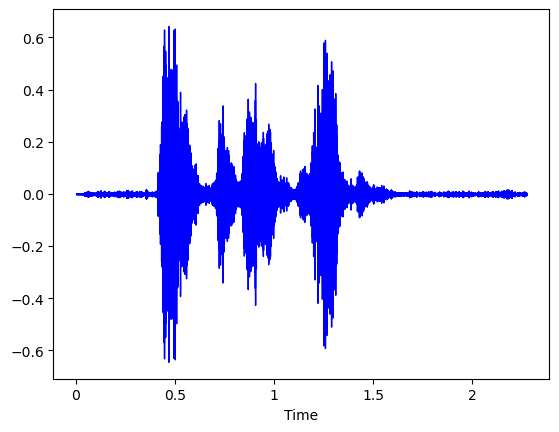

In [10]:
anger_sample = librosa.load(df['path'][0])[0]
librosa.display.waveshow(anger_sample, color="blue")

**Sample for Disgust**

In [11]:
IPython.display.Audio(df['path'][1])

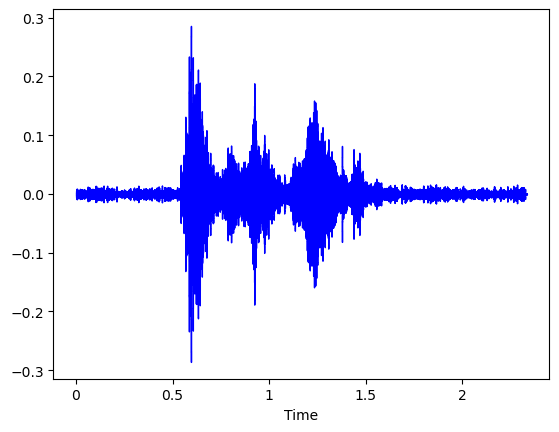

In [12]:
disgust_sample = librosa.load(df['path'][1])[0]
librosa.display.waveshow(disgust_sample, color="blue")

**Sample for Fear**

In [13]:
IPython.display.Audio(df['path'][2])

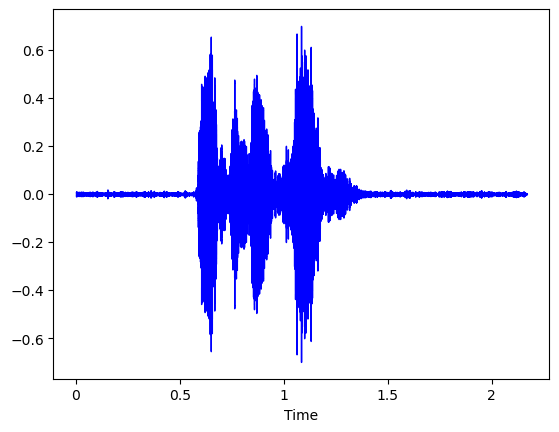

In [14]:
fear_sample = librosa.load(df['path'][2])[0]
librosa.display.waveshow(fear_sample, color="blue")

**Sample for Happiness**

In [15]:
IPython.display.Audio(df['path'][3])

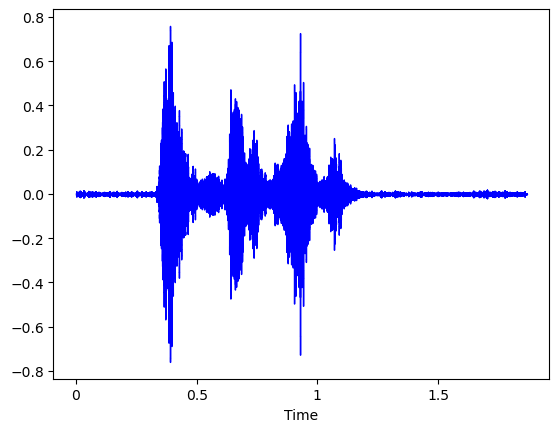

In [16]:
happiness_sample = librosa.load(df['path'][3])[0]
librosa.display.waveshow(happiness_sample, color="blue")

**Sample for Neutral**

In [17]:
IPython.display.Audio(df['path'][4])

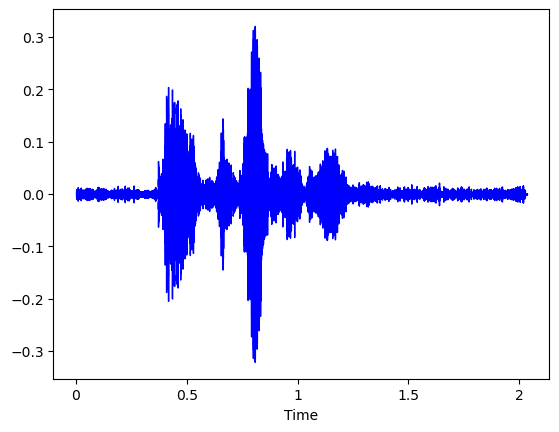

In [18]:
neutral_sample = librosa.load(df['path'][4])[0]
librosa.display.waveshow(neutral_sample, color="blue")

**Sample for Sadness**

In [19]:
IPython.display.Audio(df['path'][5])

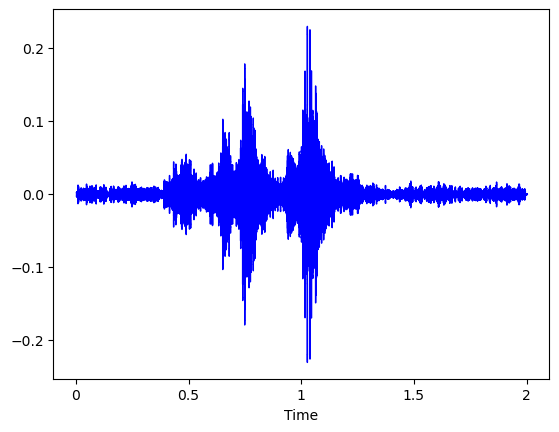

In [20]:
sadness_sample = librosa.load(df['path'][5])[0]
librosa.display.waveshow(sadness_sample, color="blue")

### Preparing Dataset

**Loading Audio into DataFrame**

In [21]:
X = []
audio_sampling = []
length = []
audio_arrays = []

for i in df['path']:
    x, sr = librosa.load(i, sr=44100)
    X.append(x)
    audio_sampling.append(sr)
    length.append(len(x))
    audio_arrays.append(x)
    
X = np.array(X, dtype='object')

**Transforming Labels**

In [22]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))
y

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [23]:
le_name_mapping = dict(zip(le.classes_, utils.to_categorical(le.transform(le.classes_))))
le_name_mapping

{'ANG': array([1., 0., 0., 0., 0., 0.], dtype=float32),
 'DIS': array([0., 1., 0., 0., 0., 0.], dtype=float32),
 'FEA': array([0., 0., 1., 0., 0., 0.], dtype=float32),
 'HAP': array([0., 0., 0., 1., 0., 0.], dtype=float32),
 'NEU': array([0., 0., 0., 0., 1., 0.], dtype=float32),
 'SAD': array([0., 0., 0., 0., 0., 1.], dtype=float32)}

## 2. Create the Feature Space (30 Points)
We will create two feature spaces from the audio.

a. You can work on time domain, or you can work in frequency domain. There are multiple of features that can help improving the model:
>i. Zero crossing rate: The rate of sign-changes of the signal during the duration of a particular frame.
<br/>ii. Energy: The sum of squares of the signal values, normalized by the respective frame length.

b. Convert the audio waveform to mel spectrogram and use this as the
feature space.

**Splitting into training, validation and test sets**

In [24]:
_, _, _, _, indices_train_val, indices_test = train_test_split(X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y)
_, _, _, _, indices_train, indices_val = train_test_split(X[indices_train_val], y[indices_train_val], indices_train_val, test_size=0.05, random_state=42, stratify=y[indices_train_val])

In [25]:
len(indices_train)

4948

In [26]:
len(indices_val)

261

In [27]:
len(indices_test)

2233

**Split on Audio Data**

In [28]:
X_train = X[indices_train]
X_val = X[indices_val]
X_test = X[indices_test]

**Split on Label Data**

In [29]:
y_train = y[indices_train]
y_val = y[indices_val]
y_test = y[indices_test]

### Data Augmentation

In [30]:
def awgn(data):
    noise_amp = 0.055 * np.random.uniform() * np.amax(data)
    data += noise_amp * np.random.normal(size=data.shape[0])
    return data

In [31]:
def pitch(data, sr=44100, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=1/pitch_factor)

In [32]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

In [33]:
def time_shift(data, sr=44100, shift_limit=1):
    shift_amt = int(random.random() * shift_limit * len(data))
    return np.roll(data, shift_amt)

In [34]:
def data_augment(X, y, aug_techniques=(awgn, pitch, time_shift)):
    awgn, pitch, time_shift = aug_techniques
    X_aug = []
    y_aug = []
    
    for i in range(len(X)):
        # Adding Original data
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        # Adding AWGN and Time Shift
        X_aug.append(awgn(time_shift(X[i])))
        y_aug.append(y[i])
        
        # Applying Pitch and Time Shift
        X_aug.append(pitch(time_shift(X[i])))
        y_aug.append(y[i])
        
    
    X_aug = np.array(X_aug, dtype='object')
    y_aug = np.array(y_aug)
    
    return X_aug, y_aug

In [35]:
X_aug_train, y_aug_train = data_augment(X_train, y_train)

In [36]:
X_aug_train.shape

(14844,)

In [37]:
y_aug_train.shape

(14844, 6)

### Time Domain

**Feature Extraction**

In [38]:
def extract_time_features(X):
    result = []
    for i, sample in enumerate(X):
        zcr = list(librosa.feature.zero_crossing_rate(y=sample.astype(float))[0])
        rmse = list(librosa.feature.rms(y=sample.astype(float))[0])
        zcr += rmse
        result.append(zcr)
    return np.array(result, dtype='object')

_Without Augmentation_

In [39]:
X_t_train = extract_time_features(X_train)

In [40]:
X_t_val = extract_time_features(X_val)

In [41]:
X_t_test = extract_time_features(X_test)

_With Augmentation_

In [42]:
X_aug_t_train = extract_time_features(X_aug_train)

**Padding Feature Space**

In [43]:
def pad_dataset(X, m):
    X_padded = []
    for i, sample in enumerate(X):
        audio_length = len(sample)
        if (audio_length <= m):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, m - audio_length)
            pad_end_len = m - audio_length - pad_begin_len
            X_padded.append(np.pad(sample, (pad_begin_len, pad_end_len), 'constant'))
    
    return np.array(X_padded)

In [44]:
max_pad = max(find_max_list_len(X_t_train), find_max_list_len(X_t_val), find_max_list_len(X_t_test))
max_pad

864

_Without Augmentation_

In [45]:
X_t_train = pad_dataset(X_t_train, max_pad)
X_t_train.shape

(4948, 864)

In [46]:
X_t_val = pad_dataset(X_t_val, max_pad)
X_t_val.shape

(261, 864)

In [47]:
X_t_test = pad_dataset(X_t_test, max_pad)
X_t_test.shape

(2233, 864)

_With Augmentation_

In [48]:
X_aug_t_train = pad_dataset(X_aug_t_train, max_pad)
X_aug_t_train.shape

(14844, 864)

### Mel Spectrogram

In [49]:
def mel_spectrogram(X, sr=44100, spec_shape=(128, 128)):
    X_mel = []
    for data in X:
        sgram = librosa.stft(data)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        
        img = Image.fromarray(mel_sgram)
        img = np.asarray(img.resize(spec_shape, resample=Image.LANCZOS))
        
        X_mel.append(img)
    
    return np.array(X_mel)

_Without Augmentation_

In [50]:
X_f_train = mel_spectrogram(X_train)

In [51]:
X_f_val = mel_spectrogram(X_val)

In [52]:
X_f_test = mel_spectrogram(X_test)

_With Augmentation_

In [53]:
X_aug_f_train = mel_spectrogram(X_aug_train)

## 3. Building the Model (40 Points)

a. Split the data into 70% training and validation and 30% testing.

b. Use 5% of the training and validation data for validation.

c. CNN Model:
Build a CNN architecture of your own. For the time domain or frequency domain feature space, the feature space will be 1 dimensional, therefore in the architecture we will be using 1D convolutions. While in melspectogram feature space, the audio is represented as an image, therefore we will be using 2D convolutions. N.B. Do not use the built-in models, but you can implement them from scratch.

Don’t forget to set seed 42 and stratify to true!!

**Callbacks**

In [54]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr /= 3
    return lr

lrs = LearningRateScheduler(lr_scheduler)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

**Model Definition and Training**

**This is a modified implementation of:**

[Zhao, Jianfeng & Mao, Xia & Chen, Lijiang. (2019). Speech emotion recognition using deep 1D & 2D CNN LSTM networks. Biomedical Signal Processing and Control. 47. 312-323. 10.1016/j.bspc.2018.08.035.](https://www.sciencedirect.com/science/article/abs/pii/S1746809418302337)

### Time Domain

In [55]:
def model_1d(input_shape):
    model = Sequential()
    
    # LFLB1
    model.add(Conv1D(filters=64, kernel_size=(3), strides=1, padding='same', data_format='channels_last', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB2
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB3
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LFLB4
    model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('elu'))
    model.add(MaxPooling1D(pool_size=4, strides=4))
    
    # LSTM
    model.add(LSTM(units=64, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(units=64, return_sequences=False))
    
    # FC
    model.add(Dense(units=6, activation='softmax'))

    return model

_Without Augmentation (With SGD optimizer)_

In [56]:
model_t_sgd = model_1d((X_t_train.shape[1], 1))

# Model compilation
model_t_sgd.compile(optimizer=optimizers.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model_t_sgd.summary()

C:\Users\user\miniconda3\envs\tensorflow\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 864, 64)           256       
                                                                 
 batch_normalization (BatchN  (None, 864, 64)          256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 864, 64)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 216, 64)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 216, 64)           12352     
                                                                 
 batch_normalization_1 (Batc  (None, 216, 64)          2

In [57]:
history_t_sgd = model_t_sgd.fit(X_t_train,
                      y_train,
                      batch_size=32,
                      epochs=200,
                      validation_data=(X_t_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_t_sgd.h5', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
                     )

Epoch 1/200
155/155 [==============================] - ETA: 0s - loss: 1.7905 - accuracy: 0.1851
Epoch 1: val_loss improved from inf to 1.79347, saving model to model_t_sgd.h5
155/155 [==============================] - 33s 159ms/step - loss: 1.7905 - accuracy: 0.1851 - val_loss: 1.7935 - val_accuracy: 0.1456 - lr: 1.0000e-04
Epoch 2/200
155/155 [==============================] - ETA: 0s - loss: 1.7828 - accuracy: 0.2255
Epoch 2: val_loss did not improve from 1.79347
155/155 [==============================] - 20s 127ms/step - loss: 1.7828 - accuracy: 0.2255 - val_loss: 1.7943 - val_accuracy: 0.1456 - lr: 1.0000e-04
Epoch 3/200
155/155 [==============================] - ETA: 0s - loss: 1.7766 - accuracy: 0.2536
Epoch 3: val_loss improved from 1.79347 to 1.79055, saving model to model_t_sgd.h5
155/155 [==============================] - 19s 120ms/step - loss: 1.7766 - accuracy: 0.2536 - val_loss: 1.7905 - val_accuracy: 0.1456 - lr: 1.0000e-04
Epoch 4/200
155/155 [==========================

In [58]:
test_loss_t_sgd, test_acc_t_sgd = model_t_sgd.evaluate(X_t_test, y_test)

70/70 [==============================] - 2s 35ms/step - loss: 1.7564 - accuracy: 0.2821


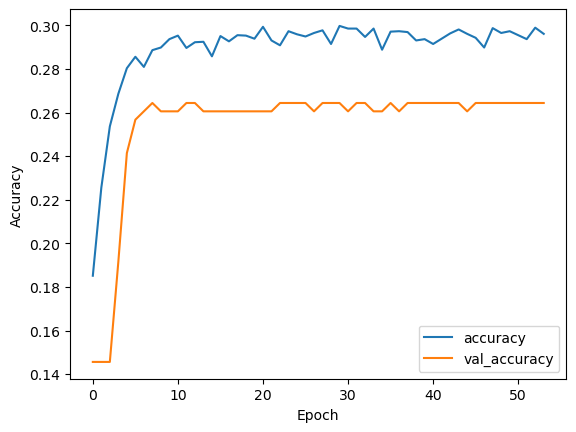

In [59]:
plt.plot(history_t_sgd.history['accuracy'], label='accuracy')
plt.plot(history_t_sgd.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

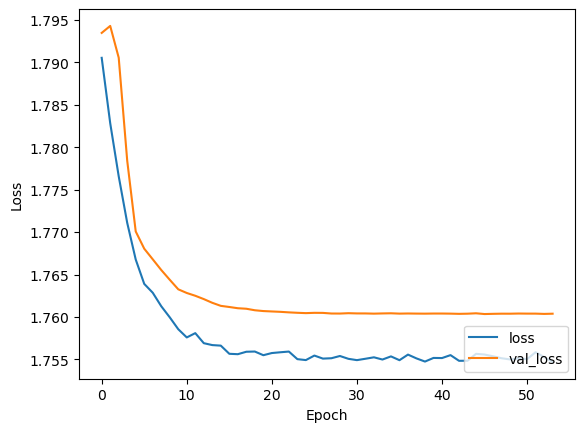

In [60]:
plt.plot(history_t_sgd.history['loss'], label='loss')
plt.plot(history_t_sgd.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_Without Augmentation (With Adam optimizer)_

In [61]:
model_t_adam = model_1d((X_t_train.shape[1], 1))

# Model compilation
model_t_adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_t_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 864, 64)           256       
                                                                 
 batch_normalization_4 (Batc  (None, 864, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 864, 64)           0         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 216, 64)          0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 216, 64)           12352     
                                                                 
 batch_normalization_5 (Batc  (None, 216, 64)         

In [62]:
history_t_adam = model_t_adam.fit(X_t_train,
                    y_train,
                    batch_size=16,
                    epochs=300,
                    validation_data=(X_t_val, y_val),
                    callbacks=[
                        es, 
                        ModelCheckpoint('model_t_adam.h5', monitor='val_loss', save_best_only=True, verbose=1),
                        lrs
                    ]
                   )

Epoch 1/300
310/310 [==============================] - ETA: 0s - loss: 1.6757 - accuracy: 0.2965
Epoch 1: val_loss improved from inf to 1.92657, saving model to model_t_adam.h5
310/310 [==============================] - 26s 63ms/step - loss: 1.6757 - accuracy: 0.2965 - val_loss: 1.9266 - val_accuracy: 0.1686 - lr: 1.0000e-04
Epoch 2/300
309/310 [============================>.] - ETA: 0s - loss: 1.5155 - accuracy: 0.3732
Epoch 2: val_loss did not improve from 1.92657
310/310 [==============================] - 18s 57ms/step - loss: 1.5154 - accuracy: 0.3735 - val_loss: 2.1034 - val_accuracy: 0.1954 - lr: 1.0000e-04
Epoch 3/300
309/310 [============================>.] - ETA: 0s - loss: 1.4354 - accuracy: 0.4132
Epoch 3: val_loss improved from 1.92657 to 1.53105, saving model to model_t_adam.h5
310/310 [==============================] - 18s 57ms/step - loss: 1.4353 - accuracy: 0.4131 - val_loss: 1.5311 - val_accuracy: 0.3870 - lr: 1.0000e-04
Epoch 4/300
309/310 [===========================

In [63]:
test_loss_t_adam, test_acc_t_adam = model_t_adam.evaluate(X_t_test, y_test)

70/70 [==============================] - 2s 31ms/step - loss: 1.3551 - accuracy: 0.4631


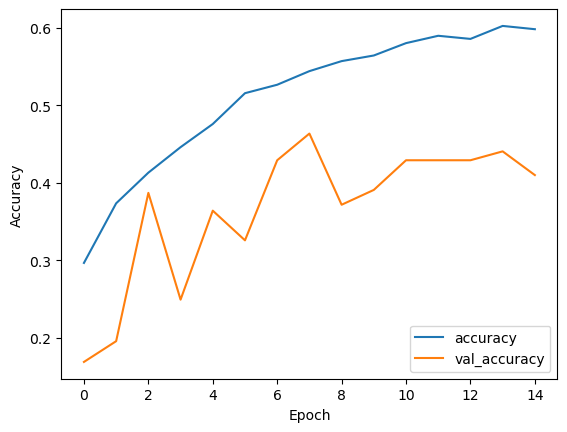

In [64]:
plt.plot(history_t_adam.history['accuracy'], label='accuracy')
plt.plot(history_t_adam.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

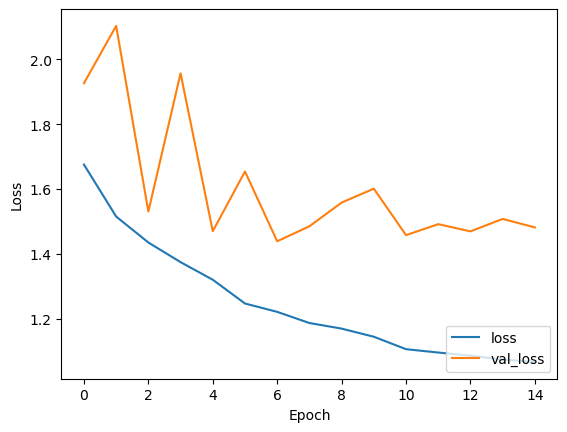

In [65]:
plt.plot(history_t_adam.history['loss'], label='loss')
plt.plot(history_t_adam.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augementation (with SGD optimizer)_

In [67]:
model_aug_t_sgd = model_1d((X_aug_t_train.shape[1], 1))

# Model compilation
model_aug_t_sgd.compile(optimizer=optimizers.SGD(learning_rate=0.0003, decay=1e-6, momentum=0.9, nesterov=True), loss='categorical_crossentropy', metrics=['accuracy'])
model_aug_t_sgd.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 864, 64)           256       
                                                                 
 batch_normalization_8 (Batc  (None, 864, 64)          256       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 864, 64)           0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 216, 64)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 216, 64)           12352     
                                                                 
 batch_normalization_9 (Batc  (None, 216, 64)         

In [68]:
history_aug_t_sgd = model_aug_t_sgd.fit(X_aug_t_train,
                      y_aug_train,
                      batch_size=32,
                      epochs=200,
                      validation_data=(X_t_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_aug_t_sgd.h5', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
                     )

Epoch 1/200
464/464 [==============================] - ETA: 0s - loss: 1.7762 - accuracy: 0.2233
Epoch 1: val_loss improved from inf to 1.78626, saving model to model_aug_t_sgd.h5
464/464 [==============================] - 52s 98ms/step - loss: 1.7762 - accuracy: 0.2233 - val_loss: 1.7863 - val_accuracy: 0.1839 - lr: 3.0000e-04
Epoch 2/200
464/464 [==============================] - ETA: 0s - loss: 1.7503 - accuracy: 0.2657
Epoch 2: val_loss improved from 1.78626 to 1.74227, saving model to model_aug_t_sgd.h5
464/464 [==============================] - 44s 95ms/step - loss: 1.7503 - accuracy: 0.2657 - val_loss: 1.7423 - val_accuracy: 0.2605 - lr: 3.0000e-04
Epoch 3/200
464/464 [==============================] - ETA: 0s - loss: 1.7283 - accuracy: 0.2762
Epoch 3: val_loss improved from 1.74227 to 1.72309, saving model to model_aug_t_sgd.h5
464/464 [==============================] - 44s 96ms/step - loss: 1.7283 - accuracy: 0.2762 - val_loss: 1.7231 - val_accuracy: 0.2529 - lr: 3.0000e-04
Ep

In [69]:
test_loss_aug_t_sgd, test_acc_aug_t_sgd = model_aug_t_sgd.evaluate(X_t_test, y_test)

70/70 [==============================] - 2s 29ms/step - loss: 1.6043 - accuracy: 0.3327


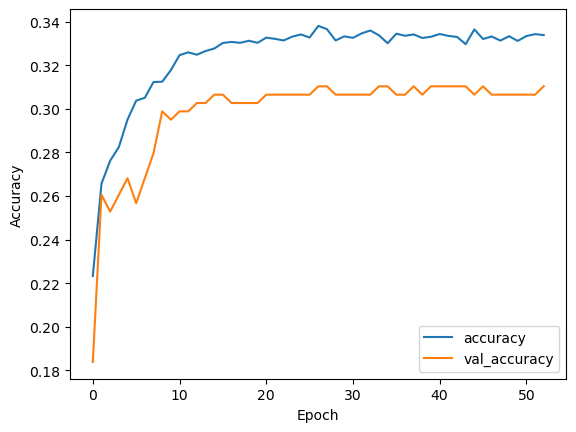

In [70]:
plt.plot(history_aug_t_sgd.history['accuracy'], label='accuracy')
plt.plot(history_aug_t_sgd.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

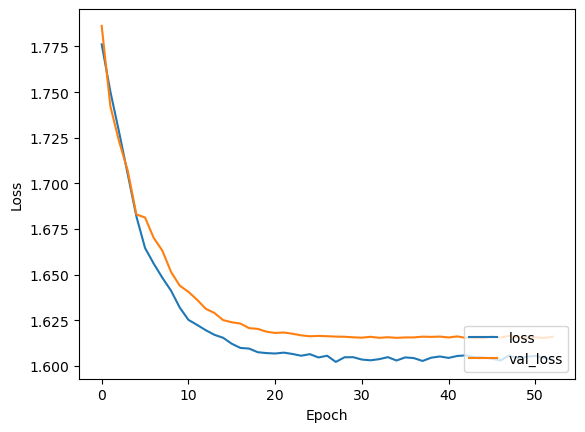

In [71]:
plt.plot(history_aug_t_sgd.history['loss'], label='loss')
plt.plot(history_aug_t_sgd.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augmentation (with Adam optimizer)_

In [72]:
model_aug_t_adam = model_1d((X_aug_t_train.shape[1], 1))

# Model compilation
model_aug_t_adam.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_aug_t_adam.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 864, 64)           256       
                                                                 
 batch_normalization_12 (Bat  (None, 864, 64)          256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, 864, 64)           0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 216, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 216, 64)           12352     
                                                                 
 batch_normalization_13 (Bat  (None, 216, 64)         

In [73]:
history_aug_t_adam = model_aug_t_adam.fit(
    X_aug_t_train,
    y_aug_train,
    batch_size=32,
    epochs=200,
    validation_data=(X_t_val, y_val),
    callbacks=[
        es,
        ModelCheckpoint('model_aug_t_adam.h5', monitor='val_loss', save_best_only=True, verbose=1),
        lrs
    ]
)

Epoch 1/200
464/464 [==============================] - ETA: 0s - loss: 1.6558 - accuracy: 0.2964
Epoch 1: val_loss improved from inf to 1.96401, saving model to model_aug_t_adam.h5
464/464 [==============================] - 57s 108ms/step - loss: 1.6558 - accuracy: 0.2964 - val_loss: 1.9640 - val_accuracy: 0.1724 - lr: 1.0000e-04
Epoch 2/200
464/464 [==============================] - ETA: 0s - loss: 1.5146 - accuracy: 0.3735
Epoch 2: val_loss improved from 1.96401 to 1.49358, saving model to model_aug_t_adam.h5
464/464 [==============================] - 53s 114ms/step - loss: 1.5146 - accuracy: 0.3735 - val_loss: 1.4936 - val_accuracy: 0.3870 - lr: 1.0000e-04
Epoch 3/200
464/464 [==============================] - ETA: 0s - loss: 1.4557 - accuracy: 0.4091
Epoch 3: val_loss did not improve from 1.49358
464/464 [==============================] - 50s 107ms/step - loss: 1.4557 - accuracy: 0.4091 - val_loss: 1.6336 - val_accuracy: 0.2874 - lr: 1.0000e-04
Epoch 4/200
464/464 [================

In [74]:
test_loss_aug_t_adam, test_acc_aug_t_adam = model_aug_t_adam.evaluate(X_t_test, y_test)

70/70 [==============================] - 2s 28ms/step - loss: 1.3433 - accuracy: 0.4689


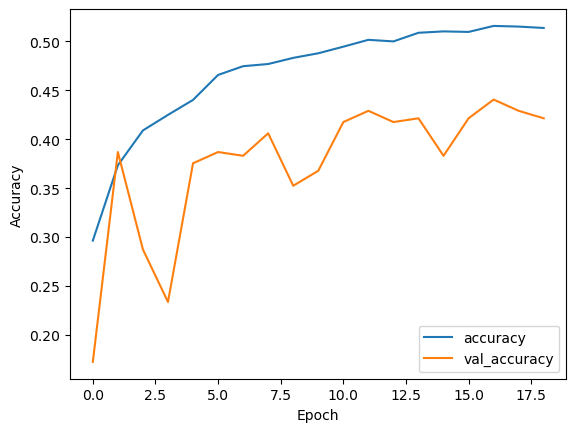

In [75]:
plt.plot(history_aug_t_adam.history['accuracy'], label='accuracy')
plt.plot(history_aug_t_adam.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

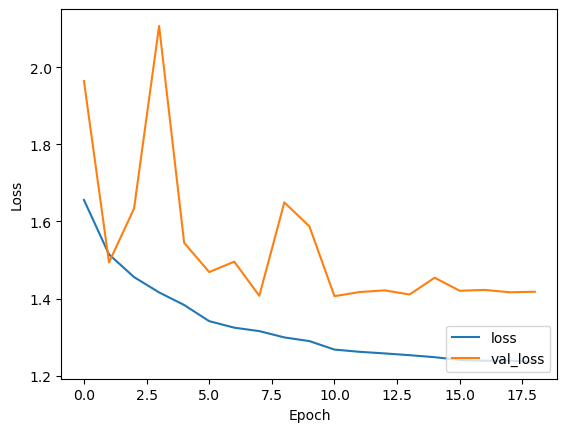

In [76]:
plt.plot(history_aug_t_adam.history['loss'], label='loss')
plt.plot(history_aug_t_adam.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### Frequency Domain

In [77]:
def model_2d(input_shape):
    # Define the model architecture
    model = tf.keras.Sequential()
    
    # Add the layers
    # LFLB1
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # LFLB2
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB3
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB4
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    #LSTM
    model.add(layers.TimeDistributed(Flatten()))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(units=64, return_sequences=False))
    
    #FC
    model.add(Dense(units=6, activation='softmax'))

    return model

_Without Augmentation_

In [78]:
model_f = model_2d((128, 128, 1))

model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model_f.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_16 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_16 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_17 (Bat  (None, 64, 64, 64)      

In [79]:
history_f = model_f.fit(X_f_train,
                      y_train,
                      batch_size=16,
                      epochs=20,
                      validation_data=(X_f_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('model_f.h5', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
)

Epoch 1/20
310/310 [==============================] - ETA: 0s - loss: 1.6087 - accuracy: 0.3664
Epoch 1: val_loss improved from inf to 1.47590, saving model to model_f.h5
310/310 [==============================] - 101s 305ms/step - loss: 1.6087 - accuracy: 0.3664 - val_loss: 1.4759 - val_accuracy: 0.3985 - lr: 1.0000e-04
Epoch 2/20
310/310 [==============================] - ETA: 0s - loss: 1.4129 - accuracy: 0.4462
Epoch 2: val_loss improved from 1.47590 to 1.36929, saving model to model_f.h5
310/310 [==============================] - 93s 299ms/step - loss: 1.4129 - accuracy: 0.4462 - val_loss: 1.3693 - val_accuracy: 0.4559 - lr: 1.0000e-04
Epoch 3/20
310/310 [==============================] - ETA: 0s - loss: 1.2922 - accuracy: 0.5075
Epoch 3: val_loss improved from 1.36929 to 1.33961, saving model to model_f.h5
310/310 [==============================] - 93s 301ms/step - loss: 1.2922 - accuracy: 0.5075 - val_loss: 1.3396 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 4/20
310/310 [=====

In [80]:
test_loss_f, test_acc_f = model_f.evaluate(X_f_test, y_test)

70/70 [==============================] - 12s 173ms/step - loss: 1.0759 - accuracy: 0.5898


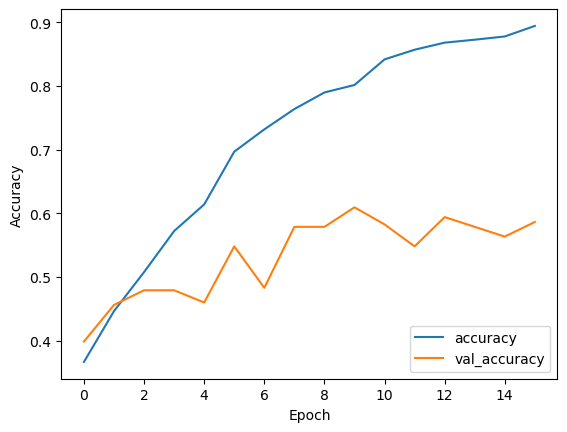

In [81]:
plt.plot(history_f.history['accuracy'], label='accuracy')
plt.plot(history_f.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

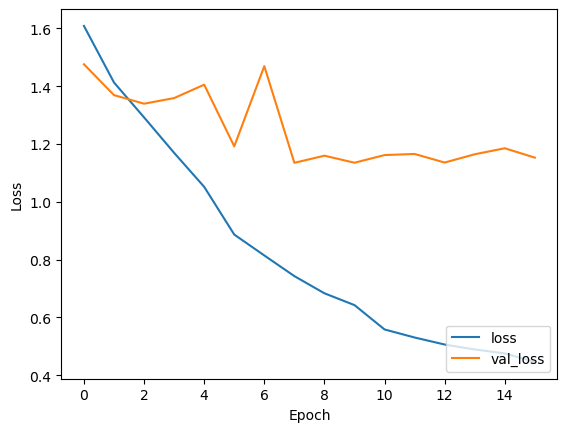

In [82]:
plt.plot(history_f.history['loss'], label='loss')
plt.plot(history_f.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

_With Augmentation_

In [83]:
model_aug_f = model_2d((128, 128, 1))
model_aug_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model_aug_f.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 batch_normalization_20 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_20 (Activation)  (None, 128, 128, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_21 (Bat  (None, 64, 64, 64)      

In [84]:
history_aug_f = model_aug_f.fit(
    X_aug_f_train,
    y_aug_train,
    batch_size=16,
    epochs=20,
    verbose=1,
    validation_data=(X_f_val, y_val),
    callbacks=[
        es,
        ModelCheckpoint('model_aug_f.h5', monitor='val_loss', save_best_only=True, verbose=1),
        lrs
    ]
)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 1.5540 - accuracy: 0.3592
Epoch 1: val_loss improved from inf to 1.43450, saving model to model_aug_f.h5
928/928 [==============================] - 297s 314ms/step - loss: 1.5540 - accuracy: 0.3592 - val_loss: 1.4345 - val_accuracy: 0.4061 - lr: 1.0000e-04
Epoch 2/20
928/928 [==============================] - ETA: 0s - loss: 1.4006 - accuracy: 0.4283
Epoch 2: val_loss improved from 1.43450 to 1.36598, saving model to model_aug_f.h5
928/928 [==============================] - 285s 307ms/step - loss: 1.4006 - accuracy: 0.4283 - val_loss: 1.3660 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 3/20
928/928 [==============================] - ETA: 0s - loss: 1.2943 - accuracy: 0.4882
Epoch 3: val_loss improved from 1.36598 to 1.31809, saving model to model_aug_f.h5
928/928 [==============================] - 281s 303ms/step - loss: 1.2943 - accuracy: 0.4882 - val_loss: 1.3181 - val_accuracy: 0.4866 - lr: 1.0000e-04
Epoch 4/20


In [85]:
test_loss_aug_f, test_acc_aug_f = model_aug_f.evaluate(X_f_test, y_test)

70/70 [==============================] - 13s 185ms/step - loss: 1.0518 - accuracy: 0.5992


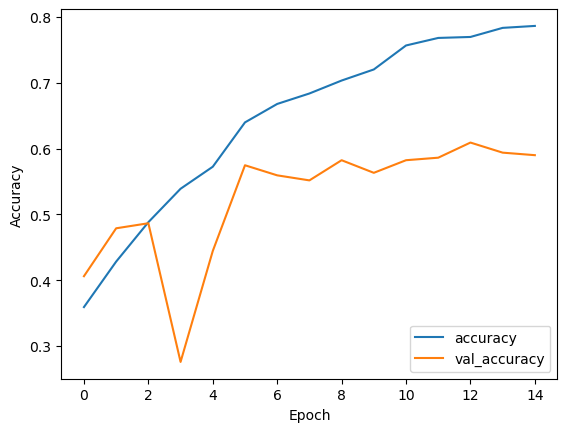

In [86]:
plt.plot(history_aug_f.history['accuracy'], label='accuracy')
plt.plot(history_aug_f.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

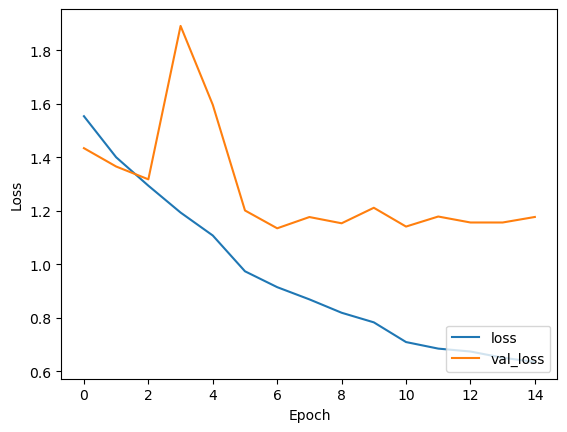

In [87]:
plt.plot(history_aug_f.history['loss'], label='loss')
plt.plot(history_aug_f.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 4. Big Picture (20 Points)

Compare between the performance of the learned models (Different features, different learning models) by realizing the following:

a. Compute the accuracy and F-Score for each model.

b. Plot the confusion matrices and find the most confusing classes.

In [88]:
def compare_performance(y_true, y_pred):
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    
    matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(matrix, annot=True, fmt="d", cmap='rocket_r', xticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'], yticklabels=['Anger', 'Disgust', 'Fear', 'Happiness', 'Neutral', 'Sadness'])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    print(classification_report(y_true, y_pred))

### Time Domain

**_Without Augmentation_**

In [89]:
y_train_pred_t = model_t_adam.predict(X_t_train)
y_val_pred_t = model_t_adam.predict(X_t_val)
y_test_pred_t = model_t_adam.predict(X_t_test)

70/70 [==============================] - 2s 26ms/step


**Training**

              precision    recall  f1-score   support

           0       0.69      0.80      0.74       845
           1       0.58      0.44      0.50       845
           2       0.51      0.33      0.40       845
           3       0.57      0.49      0.52       845
           4       0.54      0.54      0.54       723
           5       0.48      0.77      0.59       845

    accuracy                           0.56      4948
   macro avg       0.56      0.56      0.55      4948
weighted avg       0.56      0.56      0.55      4948



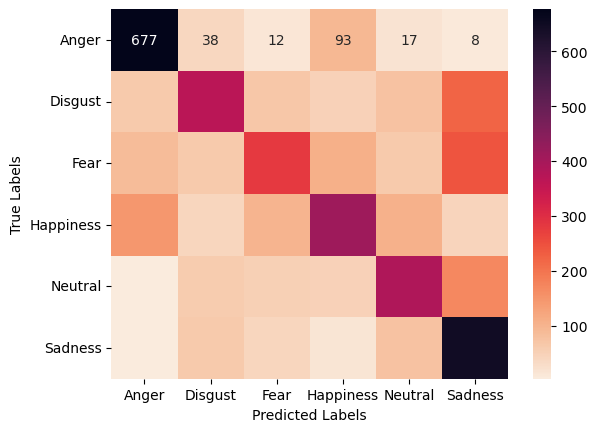

In [90]:
compare_performance(y_train, y_train_pred_t)

**Validation**

              precision    recall  f1-score   support

           0       0.56      0.62      0.59        45
           1       0.34      0.25      0.29        44
           2       0.35      0.20      0.25        45
           3       0.45      0.38      0.41        45
           4       0.40      0.47      0.43        38
           5       0.41      0.66      0.51        44

    accuracy                           0.43       261
   macro avg       0.42      0.43      0.41       261
weighted avg       0.42      0.43      0.41       261



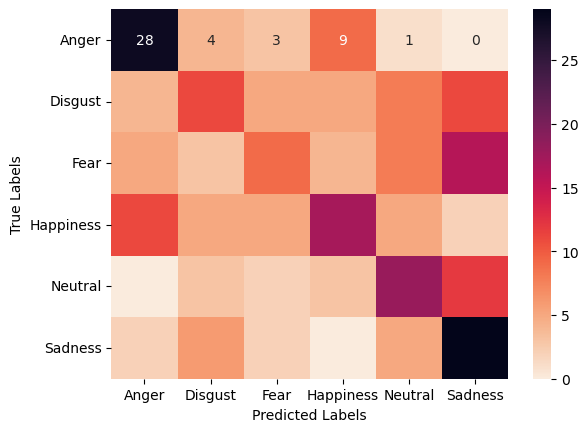

In [91]:
compare_performance(y_val, y_val_pred_t)

**Test**

              precision    recall  f1-score   support

           0       0.60      0.71      0.65       381
           1       0.45      0.36      0.40       382
           2       0.33      0.21      0.26       381
           3       0.42      0.36      0.39       381
           4       0.42      0.42      0.42       326
           5       0.46      0.70      0.56       382

    accuracy                           0.46      2233
   macro avg       0.45      0.46      0.45      2233
weighted avg       0.45      0.46      0.45      2233



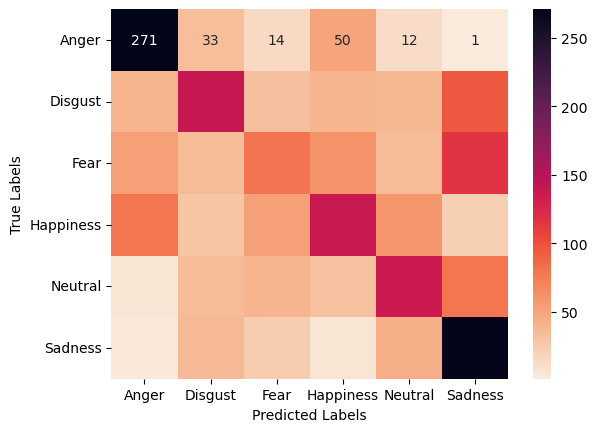

In [92]:
compare_performance(y_test, y_test_pred_t)

**_With Augmentation_**

In [93]:
y_train_pred_aug_t = model_aug_t_adam.predict(X_aug_t_train)
y_val_pred_aug_t = model_aug_t_adam.predict(X_t_val)
y_test_pred_aug_t = model_aug_t_adam.predict(X_t_test)

70/70 [==============================] - 2s 25ms/step


**Training**

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2535
           1       0.50      0.36      0.42      2535
           2       0.43      0.29      0.34      2535
           3       0.46      0.48      0.47      2535
           4       0.48      0.50      0.49      2169
           5       0.47      0.70      0.56      2535

    accuracy                           0.51     14844
   macro avg       0.51      0.51      0.50     14844
weighted avg       0.51      0.51      0.50     14844



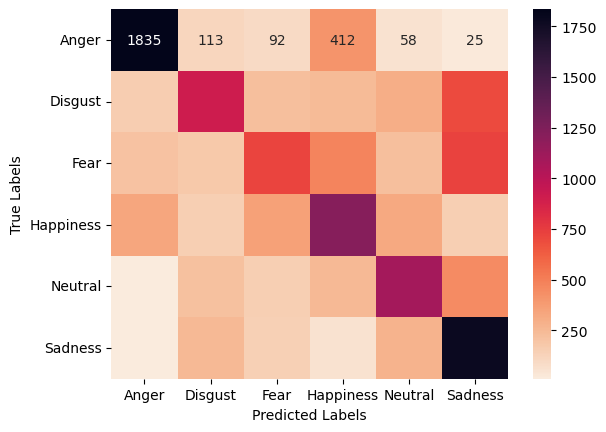

In [94]:
compare_performance(y_aug_train, y_train_pred_aug_t)

**Validation**

              precision    recall  f1-score   support

           0       0.58      0.69      0.63        45
           1       0.30      0.18      0.23        44
           2       0.31      0.20      0.24        45
           3       0.37      0.38      0.37        45
           4       0.33      0.42      0.37        38
           5       0.48      0.64      0.55        44

    accuracy                           0.42       261
   macro avg       0.40      0.42      0.40       261
weighted avg       0.40      0.42      0.40       261



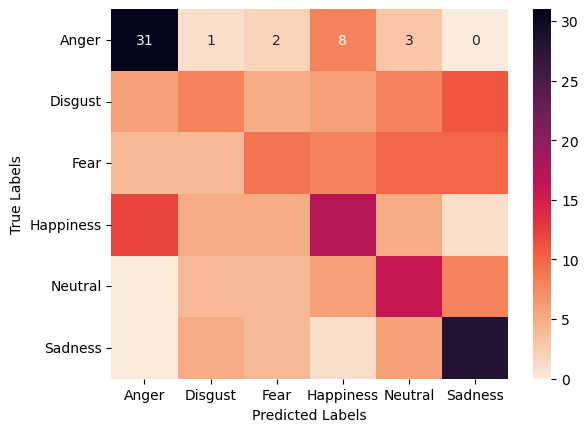

In [95]:
compare_performance(y_val, y_val_pred_aug_t)

**Test**

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       381
           1       0.48      0.32      0.38       382
           2       0.29      0.18      0.22       381
           3       0.42      0.48      0.44       381
           4       0.46      0.47      0.47       326
           5       0.48      0.71      0.57       382

    accuracy                           0.47      2233
   macro avg       0.46      0.47      0.45      2233
weighted avg       0.46      0.47      0.45      2233



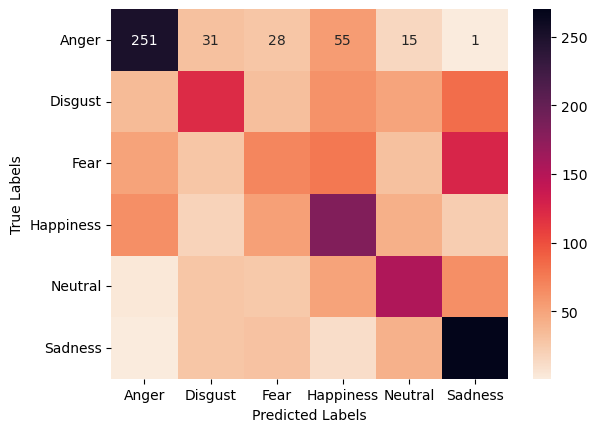

In [96]:
compare_performance(y_test, y_test_pred_aug_t)

### Frequency Domain

**_Without Augmentation_**

In [97]:
y_train_pred_f = model_f.predict(X_f_train)
y_val_pred_f = model_f.predict(X_f_val)
y_test_pred_f = model_f.predict(X_f_test)

70/70 [==============================] - 13s 183ms/step


**Training**

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       845
           1       0.85      0.65      0.73       845
           2       0.75      0.74      0.74       845
           3       0.72      0.86      0.78       845
           4       0.80      0.87      0.83       723
           5       0.81      0.75      0.78       845

    accuracy                           0.79      4948
   macro avg       0.80      0.79      0.79      4948
weighted avg       0.80      0.79      0.79      4948



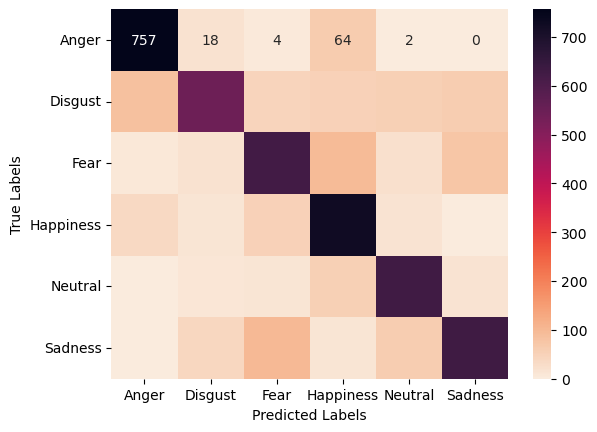

In [98]:
compare_performance(y_train, y_train_pred_f)

**Validation**

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        45
           1       0.60      0.34      0.43        44
           2       0.51      0.49      0.50        45
           3       0.52      0.67      0.58        45
           4       0.59      0.63      0.61        38
           5       0.59      0.61      0.60        44

    accuracy                           0.58       261
   macro avg       0.58      0.58      0.57       261
weighted avg       0.58      0.58      0.57       261



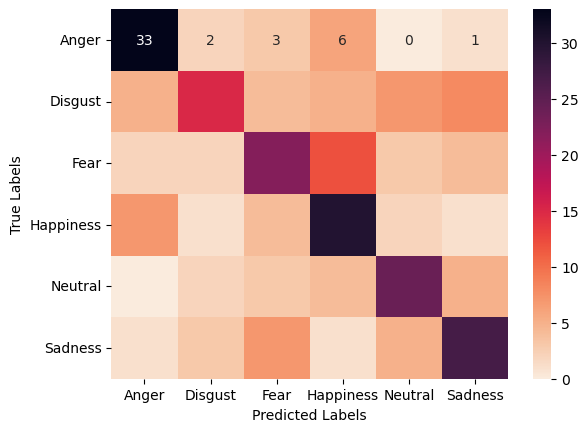

In [99]:
compare_performance(y_val, y_val_pred_f)

**Test**

              precision    recall  f1-score   support

           0       0.70      0.75      0.73       381
           1       0.60      0.39      0.47       382
           2       0.52      0.51      0.51       381
           3       0.50      0.68      0.57       381
           4       0.61      0.67      0.64       326
           5       0.66      0.55      0.60       382

    accuracy                           0.59      2233
   macro avg       0.60      0.59      0.59      2233
weighted avg       0.60      0.59      0.59      2233



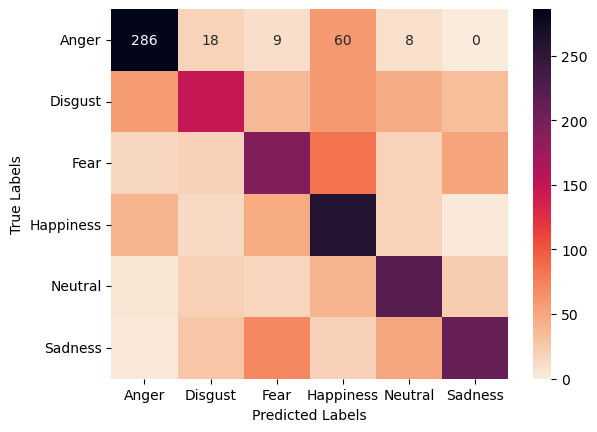

In [100]:
compare_performance(y_test, y_test_pred_f)

**_With Augmentation_**

In [101]:
y_train_pred_aug_f = model_aug_f.predict(X_aug_f_train)
y_val_pred_aug_f = model_aug_f.predict(X_f_val)
y_test_pred_aug_f = model_aug_f.predict(X_f_test)

70/70 [==============================] - 13s 181ms/step


**Training**

              precision    recall  f1-score   support

           0       0.78      0.83      0.80      2535
           1       0.77      0.45      0.57      2535
           2       0.68      0.55      0.61      2535
           3       0.67      0.72      0.70      2535
           4       0.65      0.87      0.75      2169
           5       0.62      0.73      0.67      2535

    accuracy                           0.69     14844
   macro avg       0.70      0.69      0.68     14844
weighted avg       0.70      0.69      0.68     14844



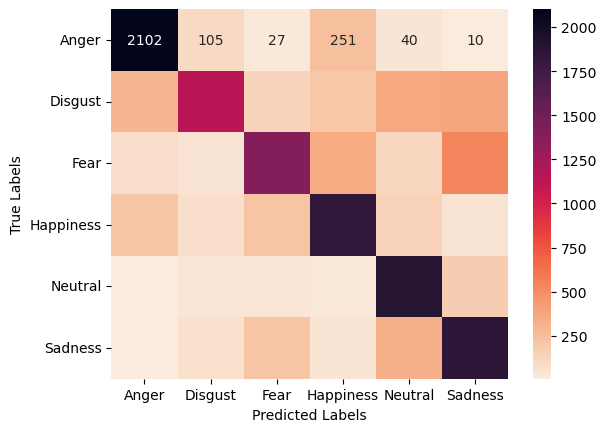

In [103]:
compare_performance(y_aug_train, y_train_pred_aug_f)

**Validation**

              precision    recall  f1-score   support

           0       0.57      0.78      0.66        45
           1       0.56      0.34      0.42        44
           2       0.63      0.42      0.51        45
           3       0.58      0.47      0.52        45
           4       0.57      0.66      0.61        38
           5       0.49      0.70      0.58        44

    accuracy                           0.56       261
   macro avg       0.57      0.56      0.55       261
weighted avg       0.57      0.56      0.55       261



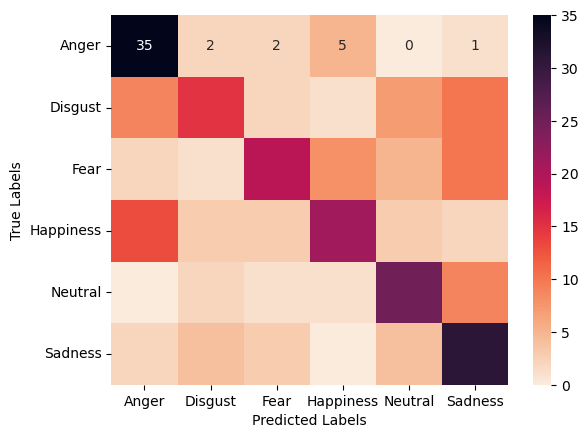

In [104]:
compare_performance(y_val, y_val_pred_aug_f)

**Test**

              precision    recall  f1-score   support

           0       0.66      0.83      0.73       381
           1       0.60      0.40      0.48       382
           2       0.57      0.40      0.47       381
           3       0.58      0.54      0.56       381
           4       0.56      0.76      0.65       326
           5       0.61      0.69      0.65       382

    accuracy                           0.60      2233
   macro avg       0.60      0.60      0.59      2233
weighted avg       0.60      0.60      0.59      2233



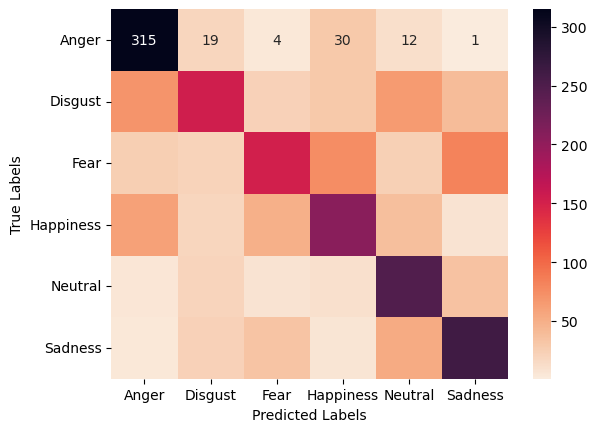

In [105]:
compare_performance(y_test, y_test_pred_aug_f)